In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from scipy import ndimage
import matplotlib.gridspec as gridspec

import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [2]:
CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"
sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")
with h5py.File(CUBE_PATH, "r") as cube:
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]
metadata_indices = metadata[:, 0]["ds_slice_idx"]

# Data exploration and processing:

In [3]:
sfrs = sfrs[sfrs.index.isin(metadata_indices)].copy()
sfrs = sfrs[sfrs["AVG"].notna()].copy()
sfrs_filtered = sfrs[sfrs["AVG"] >= -80].copy()
sfrs_flag0_filtered = sfrs_filtered[sfrs_filtered["FLAG"] == 0.0].copy()

print("Total records (before filtering):", len(sfrs))
print("Total records (after filtering AVG >= -80):", len(sfrs_filtered))
print("FLAG == 0 count:", len(sfrs_flag0_filtered))

mask_all = np.in1d(metadata_indices, sfrs_filtered.index)
mask_flag0 = np.in1d(metadata_indices, sfrs_flag0_filtered.index)
selected_all = metadata_indices[mask_all]
selected_flag0 = metadata_indices[mask_flag0]

Total records (before filtering): 34613
Total records (after filtering AVG >= -80): 30752
FLAG == 0 count: 16841


In [4]:
all_images = []
all_spectra = []
filtered_images = []
filtered_spectra = []

for zoom in range(4):
    img_key = f"dense_cube/{zoom}/ml_image/cutout_3d_cube_zoom_{zoom}"
    spec_key = f"dense_cube/{zoom}/ml_spectrum/spectral_1d_cube_zoom_{zoom}"
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom = cube[img_key][:][mask_all]
        spectra_zoom = cube[spec_key][:][mask_all]
    all_images.append(images_zoom)
    all_spectra.append(spectra_zoom)
    
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom_flag0 = cube[img_key][:][mask_flag0]
        spectra_zoom_flag0 = cube[spec_key][:][mask_flag0]
    filtered_images.append(images_zoom_flag0)
    filtered_spectra.append(spectra_zoom_flag0)

print("All images shape (zoom 0):", all_images[0].shape)
print("Filtered images shape (zoom 0):", filtered_images[0].shape)
print("All spectra shape (zoom 0):", all_spectra[0].shape)
print("Filtered spectra shape (zoom 0):", filtered_spectra[0].shape)

All images shape (zoom 0): (30752, 5, 64, 64)
Filtered images shape (zoom 0): (16841, 5, 64, 64)
All spectra shape (zoom 0): (30752, 4620)
Filtered spectra shape (zoom 0): (16841, 4620)


In [5]:
mask_clean_all = ~np.isnan(all_spectra[0]).any(axis=1)
mask_clean_flag0 = ~np.isnan(filtered_spectra[0]).any(axis=1)

cleaned_all_images = [arr[mask_clean_all] for arr in all_images]
cleaned_all_spectra = [arr[mask_clean_all] for arr in all_spectra]
cleaned_filtered_images = [arr[mask_clean_flag0] for arr in filtered_images]
cleaned_filtered_spectra = [arr[mask_clean_flag0] for arr in filtered_spectra]

selected_all_clean = selected_all[mask_clean_all]
selected_flag0_clean = selected_flag0[mask_clean_flag0]

cleaned_sfrs_all = sfrs_filtered.loc[selected_all_clean]
cleaned_sfrs_flag0 = sfrs_flag0_filtered.loc[selected_flag0_clean]

print("Cleaned All spectra shape (zoom 0):", cleaned_all_spectra[0].shape)
print("Cleaned FLAG==0 spectra shape (zoom 0):", cleaned_filtered_spectra[0].shape)

Cleaned All spectra shape (zoom 0): (20157, 4620)
Cleaned FLAG==0 spectra shape (zoom 0): (11179, 4620)


In [6]:
def normalize_images(images_list):
    normalized_list = []
    for img_array in images_list:
        min_val = np.min(img_array, axis=(2,3), keepdims=True)
        max_val = np.max(img_array, axis=(2,3), keepdims=True)
        norm_img = 2 * (img_array - min_val) / (max_val - min_val) - 1
        normalized_list.append(norm_img)
    return normalized_list

normalized_all_images = normalize_images(cleaned_all_images)
normalized_filtered_images = normalize_images(cleaned_filtered_images)

def normalize_spectra(spectra_list):
    normalized_list = []
    for spec in spectra_list:
        if spec.ndim == 1:
            spec = spec[np.newaxis, :]
        min_val = np.nanmin(spec, axis=1, keepdims=True)
        max_val = np.nanmax(spec, axis=1, keepdims=True)
        diff = np.where((max_val - min_val)==0, 1, max_val - min_val)
        norm_spec = 2 * (spec - min_val) / diff - 1
        normalized_list.append(norm_spec)
    return normalized_list

normalized_all_spectra = normalize_spectra(cleaned_all_spectra)
normalized_filtered_spectra = normalize_spectra(cleaned_filtered_spectra)

FLAG == 0 (Original): Found 1111 images with multiple objects from 11179 (9.94%).


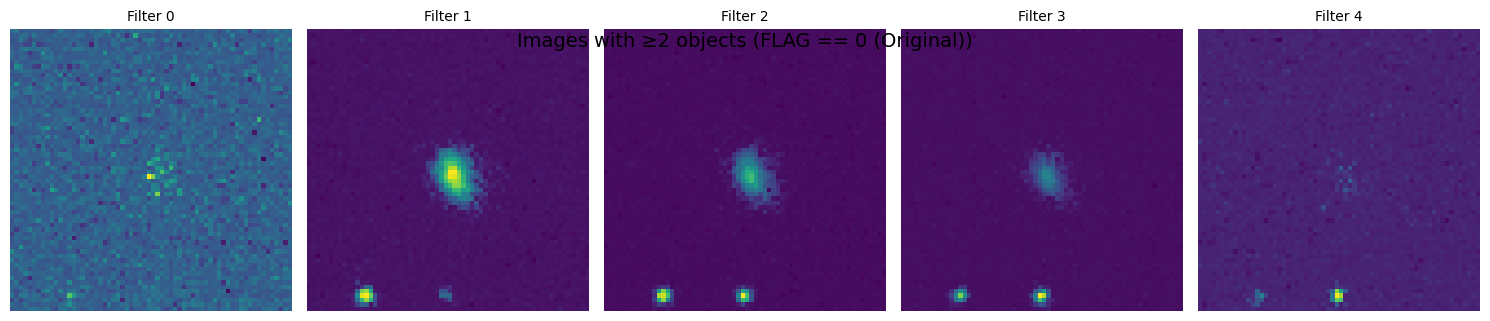

In [7]:
selected_Y_flag0 = cleaned_sfrs_flag0.loc[selected_flag0_clean]["AVG"].values

CROP_SIZES_4 = {0: 32, 1: 16, 2: 8, 3: 4} 
THRESHOLD = 0.9

def detect_and_visualize_multiple_objects(images_list, thresholds, crop_sizes=None, max_objects=1, thumbnail_size=3, group_name="", print_spectra=False, spectra_list=None):
    images_trimmed = []
    for i, img_array in enumerate(images_list):
        original_size = img_array.shape[-1]
        target_size = crop_sizes.get(i, original_size) if crop_sizes is not None else original_size
        start = (original_size - target_size) // 2
        end = start + target_size
        trimmed = img_array[..., start:end, start:end]
        images_trimmed.append(trimmed)
    multi_obj_indices = []
    for idx in range(images_trimmed[0].shape[0]):
        image = images_trimmed[0][idx, 2, :, :]
        image_normalized = (image + 1) / 2
        binary = image_normalized > thresholds
        labeled, num_features = ndimage.label(binary)
        if num_features > 1:
            multi_obj_indices.append(idx)
    total_images = images_trimmed[0].shape[0]
    count_multi = len(multi_obj_indices)
    percent_multi = (count_multi / total_images)*100 if total_images>0 else 0
    print(f"{group_name}: Found {count_multi} images with multiple objects from {total_images} ({percent_multi:.2f}%).")
    if multi_obj_indices:
        display_indices = multi_obj_indices[:max_objects]
        if print_spectra and spectra_list is not None:
            num_disp = len(display_indices)
            fig = plt.figure(figsize=(15, thumbnail_size * 2 * num_disp), dpi=100)
            gs = gridspec.GridSpec(2 * num_disp, 5, hspace=0.6, wspace=0.3)
            for i, obj_idx in enumerate(display_indices):
                for col in range(5):
                    ax = fig.add_subplot(gs[2*i, col])
                    img_data = images_trimmed[0][obj_idx, col, :, :]
                    ax.imshow(img_data, vmin=-1, vmax=1)
                    ax.set_title(f"Filter {col}", fontsize=10)
                    ax.axis("off")
                ax_spec = fig.add_subplot(gs[2*i+1, :])
                spectrum = spectra_list[0][obj_idx]
                wavelengths = np.linspace(3800,9200, len(spectrum))
                ax_spec.plot(wavelengths, spectrum, linewidth=0.3)
                ax_spec.set_title("Spectrum (Zoom 0)", fontsize=10)
                ax_spec.set_xlabel("Wavelength (Å)", fontsize=10)
                ax_spec.set_ylabel("Flux", fontsize=10)
                ax_spec.set_xlim([3800,9200])
                ax_spec.set_ylim([-1,1])
            fig.suptitle(f"Images with ≥2 objects and spectra ({group_name})", fontsize=14)
            fig.tight_layout()
            fig.subplots_adjust(top=0.93)
            plt.show()
        else:
            num_disp = len(display_indices)
            fig, axes = plt.subplots(num_disp, 5, figsize=(15, thumbnail_size * num_disp), dpi=100)
            if num_disp == 1:
                axes = axes.reshape(1, -1)
            for row, obj_idx in enumerate(display_indices):
                for col in range(5):
                    ax = axes[row, col]
                    img_data = images_trimmed[0][obj_idx, col, :, :]
                    ax.imshow(img_data, vmin=-1, vmax=1)
                    ax.set_title(f"Filter {col}", fontsize=10)
                    ax.axis("off")
            fig.suptitle(f"Images with ≥2 objects ({group_name})", fontsize=14)
            fig.tight_layout()
            fig.subplots_adjust(top=0.99)
            plt.show()
    else:
        print(f"No images found for {group_name} with multiple objects.")
    return images_trimmed, multi_obj_indices

orig_images_flag0, multi_obj_indices_flag0 = detect_and_visualize_multiple_objects(
    normalized_filtered_images, thresholds=THRESHOLD, crop_sizes=None,
    group_name="FLAG == 0 (Original)", print_spectra=False, spectra_list=normalized_filtered_spectra
)

In [8]:
X_photo_all = orig_images_flag0[0]        
X_spec_all = normalized_filtered_spectra[0]  
mask_good = np.ones(X_photo_all.shape[0], dtype=bool)
mask_good[multi_obj_indices_flag0] = False

X_photo = X_photo_all[mask_good]
X_spec = X_spec_all[mask_good]
Y = selected_Y_flag0[:X_photo_all.shape[0]][mask_good]

n_samples = min(X_photo.shape[0], X_spec.shape[0], len(Y))
X_photo = X_photo[:n_samples]
X_spec = X_spec[:n_samples]
Y = Y[:n_samples]

In [9]:
X_photo_train_val, X_photo_test, X_spec_train_val, X_spec_test, Y_train_val, Y_test = train_test_split(
    X_photo, X_spec, Y, test_size=0.2, random_state=42
)
X_photo_train, X_photo_val, X_spec_train, X_spec_val, Y_train, Y_val = train_test_split(
    X_photo_train_val, X_spec_train_val, Y_train_val, test_size=0.25, random_state=42
)

print("Train samples:", X_photo_train.shape[0])
print("Validation samples:", X_photo_val.shape[0])
print("Test samples:", X_photo_test.shape[0])

Train samples: 6040
Validation samples: 2014
Test samples: 2014


# Machine Learning (FLAG == 0 only):

## VGGNet12:

In [10]:
class CustomMSELoss(nn.Module):
    def __init__(self):
        super(CustomMSELoss, self).__init__()
    def forward(self, output, target):
        if target.dim() == 1:
            target = target.view(-1, 1)
        return F.mse_loss(output, target)

class VGGNet12(nn.Module):
    def __init__(self, input_channels, input_height, input_width, dropout=0.5):
        super(VGGNet12, self).__init__()
        if input_height == 1:
            pool1 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
            pool2 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        else:
            pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            pool1
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            pool2
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        pool_h = max(1, input_height // 8)
        pool_w = max(1, input_width // 8)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((pool_h, pool_w))
        fc_input_dim = 256 * pool_h * pool_w
        self.fc1 = nn.Linear(fc_input_dim, 512)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(128, 1)
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [11]:
def plot_history(model, fusion_name, zoom_level):
    train_losses = model.history[:, 'train_loss']
    val_losses = model.history[:, 'valid_loss']
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{fusion_name} - Training & Validation Loss (Zoom {zoom_level})')
    plt.legend()
    plt.grid(True)
    plt.show()

def run_skorch_grid_search_vgg(X_train, Y_train, X_val, Y_val, param_grid, input_channels, input_height, input_width):
    net = NeuralNetRegressor(
        module=VGGNet12,
        module__input_channels=input_channels,
        module__input_height=input_height,
        module__input_width=input_width,
        module__dropout=0.5,
        max_epochs=50,
        lr=0.001,
        optimizer=torch.optim.Adam,
        batch_size=32,
        iterator_train__shuffle=True,
        callbacks=[('early_stopping', EarlyStopping(patience=5))],
        device='cuda' if torch.cuda.is_available() else 'cpu',
        criterion=CustomMSELoss,
    )
    gs = GridSearchCV(net, param_grid, scoring='r2', cv=3)
    gs.fit(X_train, Y_train)
    best_model = gs.best_estimator_
    Y_pred = best_model.predict(X_val)
    mae = mean_absolute_error(Y_val, Y_pred)
    r2_val = r2_score(Y_val, Y_pred)
    error = Y_pred - Y_val
    nmad = 1.4826 * np.median(np.abs(error - np.median(error)))
    rmse = np.sqrt(mean_squared_error(Y_val, Y_pred))
    return gs.best_score_, gs.best_params_, mae, r2_val, nmad, rmse, best_model


param_grid_vgg = {
    'lr': [0.01, 0.001, 0.0001],
    'module__dropout': [0.5],
    'callbacks__early_stopping__patience': [10]
}

In [12]:
input_channels_photo = X_photo_train.shape[1]
input_height_photo = X_photo_train.shape[2]
input_width_photo = X_photo_train.shape[3]

X_spec_train_cnn = X_spec_train.reshape(X_spec_train.shape[0], 1, 1, X_spec_train.shape[1])
X_spec_val_cnn   = X_spec_val.reshape(X_spec_val.shape[0], 1, 1, X_spec_val.shape[1])
X_spec_test_cnn  = X_spec_test.reshape(X_spec_test.shape[0], 1, 1, X_spec_test.shape[1])
input_channels_spec = 1
input_height_spec = 1
input_width_spec = X_spec_train.shape[1]

X_spec_train_4d = X_spec_train.reshape(X_spec_train.shape[0], 1, 1, X_spec_train.shape[1])
X_spec_val_4d   = X_spec_val.reshape(X_spec_val.shape[0], 1, 1, X_spec_val.shape[1])
X_spec_test_4d  = X_spec_test.reshape(X_spec_test.shape[0], 1, 1, X_spec_test.shape[1])

target_size_train = (X_photo_train.shape[2], X_photo_train.shape[3])
target_size_val   = (X_photo_val.shape[2], X_photo_val.shape[3])
target_size_test  = (X_photo_test.shape[2], X_photo_test.shape[3])

X_spec_train_tensor = torch.from_numpy(X_spec_train_4d).float()
X_spec_val_tensor   = torch.from_numpy(X_spec_val_4d).float()
X_spec_test_tensor  = torch.from_numpy(X_spec_test_4d).float()

X_spec_train_resized = F.interpolate(X_spec_train_tensor, size=target_size_train, mode='bilinear', align_corners=False).numpy()
X_spec_val_resized   = F.interpolate(X_spec_val_tensor, size=target_size_val, mode='bilinear', align_corners=False).numpy()
X_spec_test_resized  = F.interpolate(X_spec_test_tensor, size=target_size_test, mode='bilinear', align_corners=False).numpy()

X_early_train = np.concatenate([X_photo_train, X_spec_train_resized], axis=1)
X_early_val   = np.concatenate([X_photo_val,   X_spec_val_resized], axis=1)
X_early_test  = np.concatenate([X_photo_test,  X_spec_test_resized], axis=1)

input_channels_early = X_early_train.shape[1]
input_height_early = X_early_train.shape[2]
input_width_early = X_early_train.shape[3]

runtime = {}

## Spectrum and Photo separately:

### VGGNet12 on Photo: 

  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  202758469.4379        0.5847  2.4469
      2        3.8182        0.5847  1.7012
      3        0.6319        0.5846  1.7017
      4        0.6352        0.5846  1.6784
      5        0.7104        0.5846  1.6785
      6        0.6726        0.5846  1.6839
      7        0.7321        0.5845  1.7092
      8        0.6826        0.5845  1.6893
      9        0.6594        0.5844  1.6896
     10        0.6274        0.5844  1.7078
     11        0.6244        0.5843  1.7010
     12        0.6233        0.5843  1.6871
     13        0.6236        0.5842  1.6915
     14        0.6223        0.5841  1.6954
     15        0.6276        0.5841  1.6946
     16        0.6250        0.5840  1.6950
     17        0.6224        0.5839  1.6983
     18        0.6224        0.5838  1.6962
     19        0.6220        0.5837  1.6953
     20        0.6235        0.5836  1.6964
     21        0.6253     

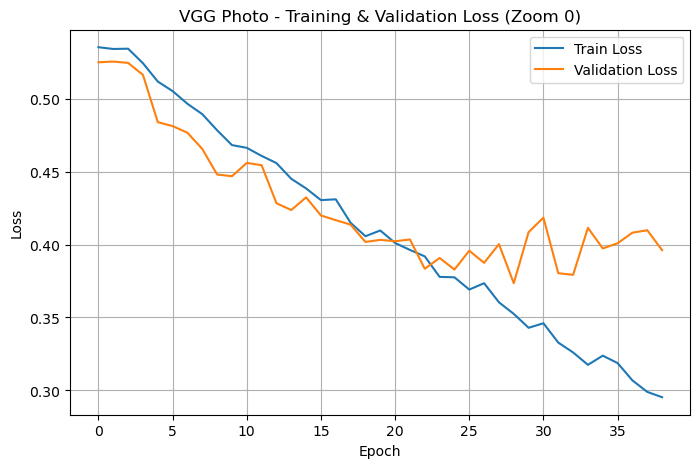

In [13]:
start = time.time()
vgg_photo_score, vgg_photo_params, vgg_photo_mae, vgg_photo_r2, vgg_photo_nmad, vgg_photo_rmse, vgg_photo_model = run_skorch_grid_search_vgg(
    X_photo_train, Y_train, X_photo_val, Y_val,
    param_grid_vgg, input_channels_photo, input_height_photo, input_width_photo
)
runtime["VGGNet Photo"] = time.time() - start
print("VGGNet Photo best params:", vgg_photo_params)
plot_history(vgg_photo_model, "VGG Photo", 0)

### VGGNet12 on Spectra:

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1     2397.9188        0.5140  10.4616
      2        0.5687        0.5044  10.4196
      3        0.5658        0.5114  10.4255
      4        0.5622        0.5119  10.4220
      5        0.5562        0.5061  10.4259
      6        0.5624        0.5179  10.4299
      7        0.5508        0.5060  10.4297
      8        0.5510        0.5074  10.4246
      9        1.0746        0.5322  10.4142
     10        0.6277        0.5232  10.4038
     11        0.5612        0.5166  10.4048
Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1     1305.0180        0.5219  10.4833
      2        0.5527        0.5079  10.4554
      3        0.5483        0.5092  10.4564
      4        0.5520        0.5148  10.4484
      5        0.5548        0.5074  10.4541
      6        0.5475        0.514

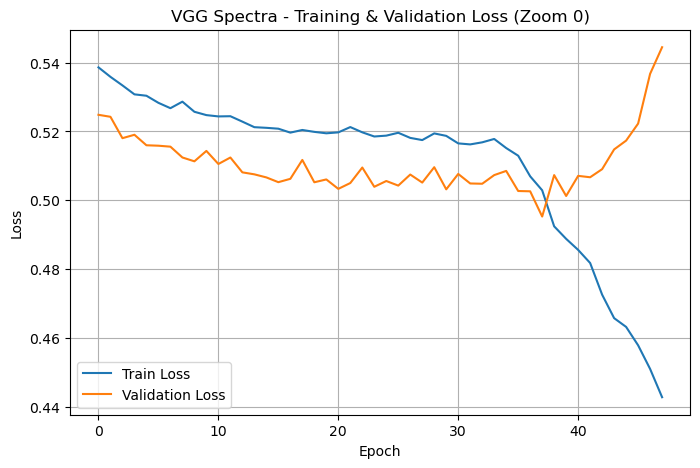

In [14]:
start = time.time()
vgg_spec_score, vgg_spec_params, vgg_spec_mae, vgg_spec_r2, vgg_spec_nmad, vgg_spec_rmse, vgg_spec_model = run_skorch_grid_search_vgg(
    X_spec_train_cnn, Y_train, X_spec_val_cnn, Y_val,
    param_grid_vgg, input_channels_spec, input_height_spec, input_width_spec
)
runtime["VGGNet Spectra"] = time.time() - start
print("VGGNet Spectra best params:", vgg_spec_params)
plot_history(vgg_spec_model, "VGG Spectra", 0)

### VGGNet12 Early Fusion:

  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  29795148.0150        0.5280  1.7366
      2   244911.5991        0.5274  1.7341
      3    23568.1731        0.5273  1.7327
      4        5.5987        0.5273  1.7344
      5        0.5623        0.5273  1.7323
      6        0.5622        0.5272  1.7327
      7  825486669.0065        0.5042  1.7370
      8  5348992670867.1250        0.8307  1.7502
      9       48.1782        0.8345  1.8144
     10      220.8768        0.8344  1.7653
     11        1.6060        0.8344  1.7339
     12        0.8518        0.8344  1.7391
     13        0.8617        0.8344  1.7380
     14        0.8518        0.8344  1.7391
     15        0.8518        0.8344  1.7376
     16        0.8518        0.8344  1.7383
Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1  9141208.8147        0.5363  1.7509

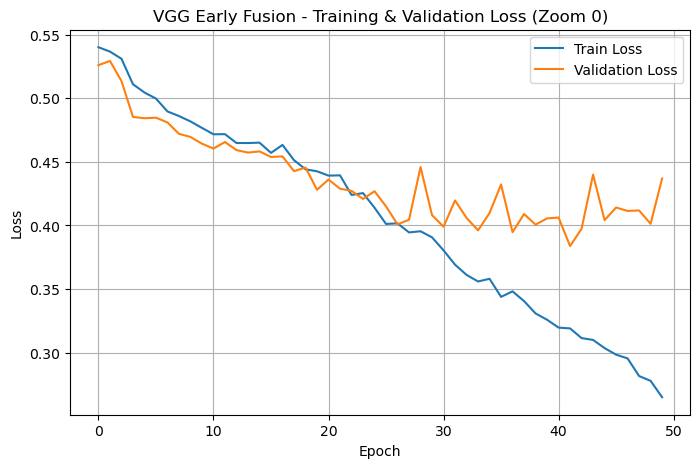

In [15]:
start = time.time()
vgg_early_score, vgg_early_params, vgg_early_mae, vgg_early_r2, vgg_early_nmad, vgg_early_rmse, vgg_early_model = run_skorch_grid_search_vgg(
    X_early_train, Y_train, X_early_val, Y_val,
    param_grid_vgg, input_channels_early, input_height_early, input_width_early
)
runtime["VGGNet Early Fusion"] = time.time() - start
print("VGGNet Early Fusion best params:", vgg_early_params)
plot_history(vgg_early_model, "VGG Early Fusion", 0)

### VGGNet12 Late Fusion:

In [16]:
Y_pred_vgg_photo_test = vgg_photo_model.predict(X_photo_test)
Y_pred_vgg_spec_test  = vgg_spec_model.predict(X_spec_test_cnn)
Y_pred_vgg_late_test  = (Y_pred_vgg_photo_test + Y_pred_vgg_spec_test) / 2.0
Y_pred_vgg_early_test = vgg_early_model.predict(X_early_test)

runtime["LGBM Late Fusion"] = runtime["VGGNet Spectra"] + runtime["VGGNet Photo"]

### Compile all results:

In [17]:
def calc_metrics(Y_true, Y_pred):
    mae = mean_absolute_error(Y_true, Y_pred)
    r2  = r2_score(Y_true, Y_pred)
    error = Y_pred - Y_true
    nmad = 1.4826 * np.median(np.abs(error - np.median(error)))
    rmse = np.sqrt(mean_squared_error(Y_true, Y_pred))
    return mae, r2, nmad, rmse

vgg_photo_mae_test,  vgg_photo_r2_test,  vgg_photo_nmad_test,  vgg_photo_rmse_test  = calc_metrics(Y_test, Y_pred_vgg_photo_test)
vgg_spec_mae_test,   vgg_spec_r2_test,   vgg_spec_nmad_test,   vgg_spec_rmse_test   = calc_metrics(Y_test, Y_pred_vgg_spec_test)
vgg_early_mae_test,  vgg_early_r2_test,  vgg_early_nmad_test,  vgg_early_rmse_test  = calc_metrics(Y_test, Y_pred_vgg_early_test)
vgg_late_mae_test,   vgg_late_r2_test,   vgg_late_nmad_test,   vgg_late_rmse_test   = calc_metrics(Y_test, Y_pred_vgg_late_test)

comparison = {
    "VGGNet Photo": {
        'r2': vgg_photo_r2_test,
        'mae': vgg_photo_mae_test,
        'nmad': vgg_photo_nmad_test,
        'rmse': vgg_photo_rmse_test
    },
    "VGGNet Spectra": {
        'r2': vgg_spec_r2_test,
        'mae': vgg_spec_mae_test,
        'nmad': vgg_spec_nmad_test,
        'rmse': vgg_spec_rmse_test
    },
    "VGGNet Early Fusion": {
        'r2': vgg_early_r2_test,
        'mae': vgg_early_mae_test,
        'nmad': vgg_early_nmad_test,
        'rmse': vgg_early_rmse_test
    },
    "VGGNet Late Fusion": {
        'r2': vgg_late_r2_test,
        'mae': vgg_late_mae_test,
        'nmad': vgg_late_nmad_test,
        'rmse': vgg_late_rmse_test
    }
}

print("\nTest Metrics:")
for method, met in comparison.items():
    print(f"{method}: R² = {met['r2']:.3f}, MAE = {met['mae']:.3f}, NMAD = {met['nmad']:.3f}, RMSE = {met['rmse']:.3f}")


Test Metrics:
VGGNet Photo: R² = 0.247, MAE = 0.471, NMAD = 0.919, RMSE = 0.625
VGGNet Spectra: R² = -0.024, MAE = 0.591, NMAD = 0.851, RMSE = 0.729
VGGNet Early Fusion: R² = 0.183, MAE = 0.497, NMAD = 0.924, RMSE = 0.651
VGGNet Late Fusion: R² = 0.251, MAE = 0.492, NMAD = 0.850, RMSE = 0.623


### Visualization of comparative metrics:

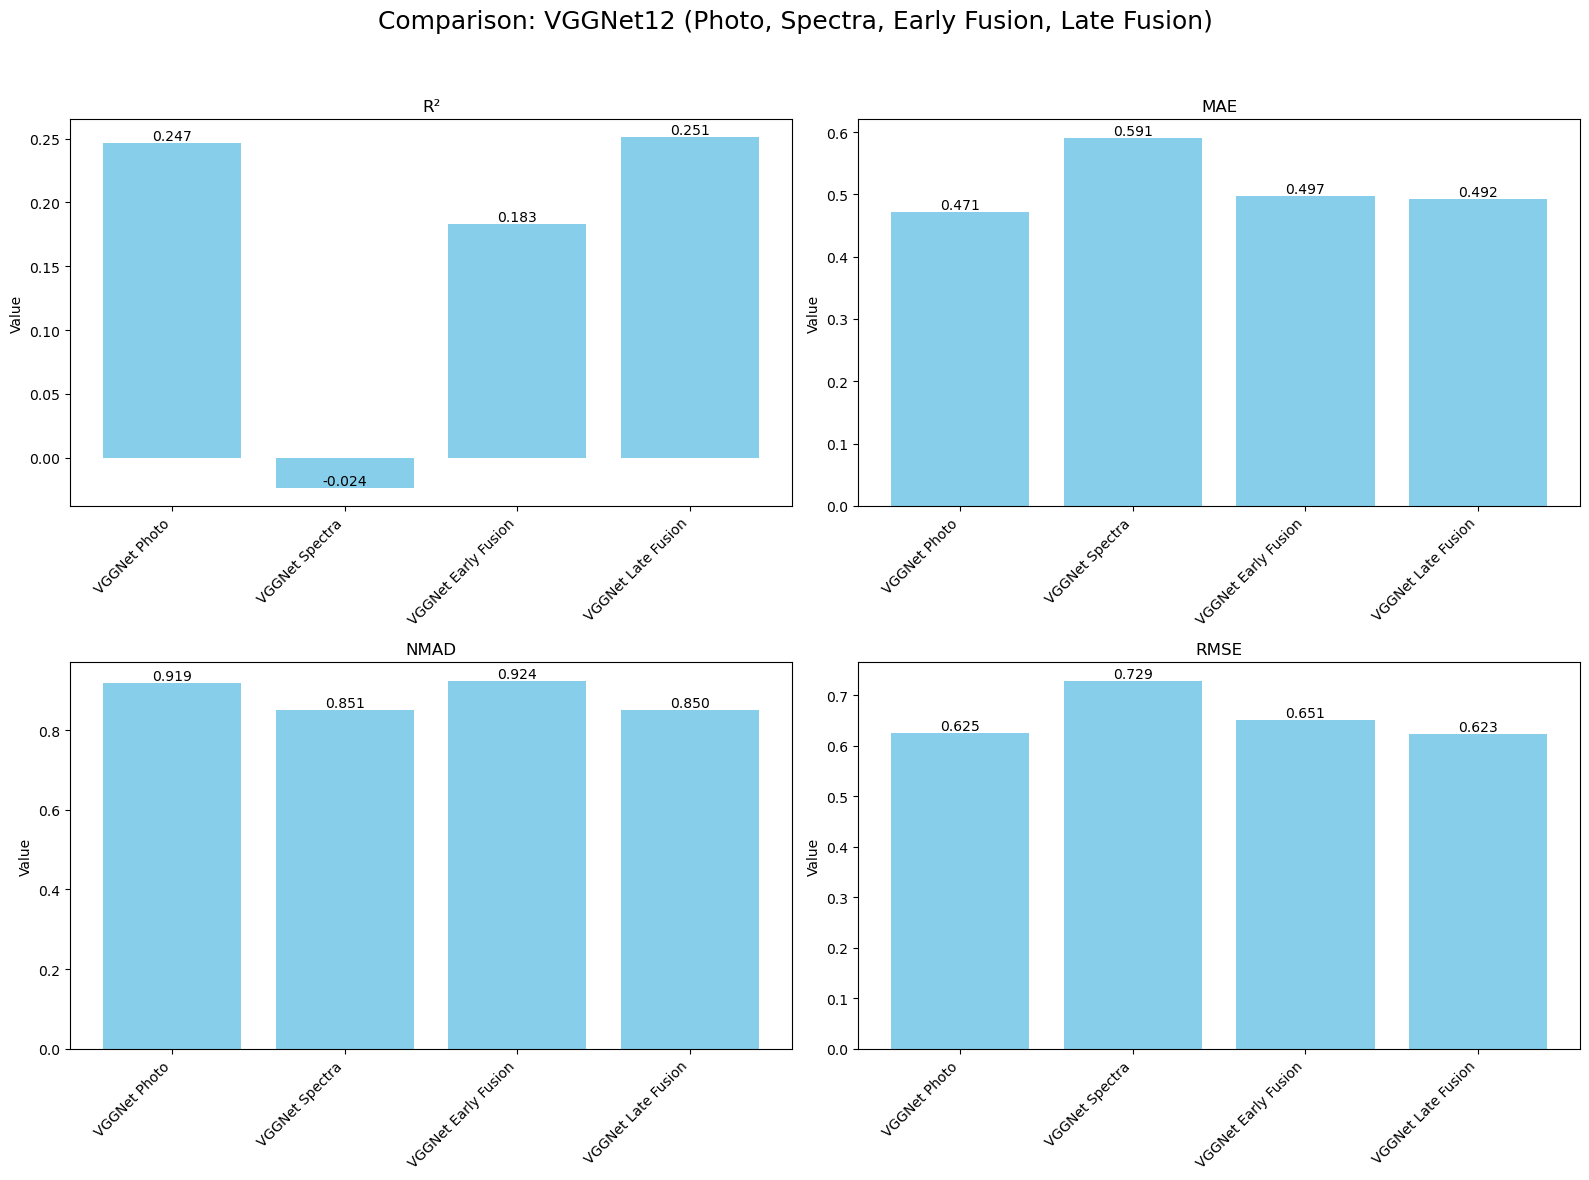

In [18]:
methods = list(comparison.keys())
metrics_names = ['R²', 'MAE', 'NMAD', 'RMSE']
values = {metric: [] for metric in metrics_names}
for method in methods:
    values['R²'].append(comparison[method]['r2'])
    values['MAE'].append(comparison[method]['mae'])
    values['NMAD'].append(comparison[method]['nmad'])
    values['RMSE'].append(comparison[method]['rmse'])

x = np.arange(len(methods))
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()
for i, metric in enumerate(metrics_names):
    axs[i].bar(x, values[metric], color='skyblue')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(methods, rotation=45, ha='right')
    axs[i].set_title(metric)
    axs[i].set_ylabel("Value")
    for j, v in enumerate(values[metric]):
        axs[i].text(j, v, f"{v:.3f}", ha='center', va='bottom', fontsize=10)
plt.suptitle("Comparison: VGGNet12 (Photo, Spectra, Early Fusion, Late Fusion)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Visualization of runtimes:

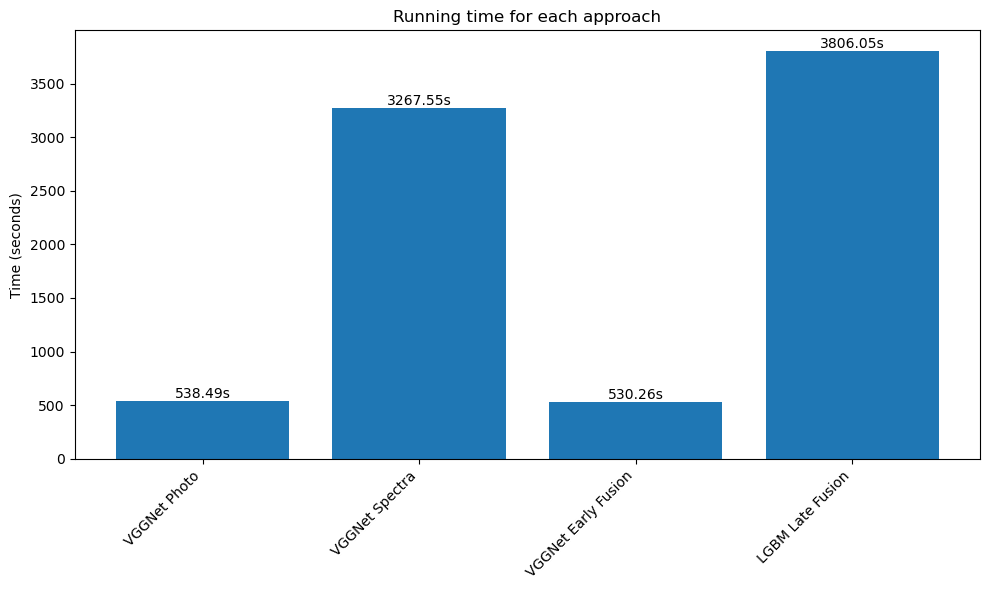

In [19]:
runtime_methods = list(runtime.keys())
runtime_values = [runtime[m] for m in runtime_methods]
plt.figure(figsize=(10, 6))
plt.bar(runtime_methods, runtime_values)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Time (seconds)")
plt.title("Running time for each approach")
for i, t in enumerate(runtime_values):
    plt.text(i, t, f"{t:.2f}s", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()